<a href="https://colab.research.google.com/github/Andron00e/CBM_Optim/blob/main/CBM_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



```
|
|
|–>generation&filtering–>CLIP–>classifier by text
|
|
```



# Packages

In [1]:
!pip install open_clip_torch
!pip install -U sentence-transformers
!pip install openai-clip
!pip install pytorchcv
!pip install -q git+https://github.com/huggingface/peft.git git+https://github.com/huggingface/transformers.git
!pip install accelerate
!pip install bitsandbytes
!pip install sentencepiece
!pip install datasets
!pip install nltk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 47.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 37.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 1.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 59.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 90.9 MB/s eta 0:00:00
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125925 sha256=dd741b7afbd60f5ab2a6ab060b9bbda44ae58ef13969e8759c3435e44860df44
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd

In [2]:
import open_clip
import clip
from torchvision.datasets import CIFAR10, CIFAR100, ImageNet
from open_clip import tokenizer
import torch
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os
from sentence_transformers import SentenceTransformer
import requests
import json
import math
import random
from tqdm import tqdm
import nltk
nltk.download("punkt")
from nltk.tokenize import WordPunctTokenizer
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [ ]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

print(color.BOLD + 'Hello, World!' + color.END)

# Generation and prompt filtering

In [3]:
LABEL_FILES = {"cifar10":"data/cifar10_classes.txt",
               "cifar100": "data/cifar100_classes.txt",
               "cub": "data/cub_classes.txt",
               "imagenet": "data/imagenet_classes.txt"}
LIMIT = 200
RELATIONS = ["HasA", "IsA", "PartOf", "HasProperty", "MadeOf", "AtLocation"]

CLASS_SIM_CUTOFF = 0.85
OTHER_SIM_CUTOFF = 0.9
MAX_LEN = 30
PRINT_PROB = 0.2

dataset = ["cifar10", "cifar100", "cub", "imagenet"]
save_name = ["data/conceptnet_{}_filtered_new.txt".format(data) for data in dataset]

### ConceptNet preprocess functions

In [8]:
def get_init_conceptnet(classes, limit=200, relations=["HasA", "IsA", "PartOf", "HasProperty", "MadeOf", "AtLocation"]):
    concepts = set()

    for cls in tqdm(classes):
        words = cls.replace(',', '').split(' ')
        for word in words:
            obj = requests.get('http://api.conceptnet.io/c/en/{}?limit={}'.format(word, limit)).json()
            obj.keys()
            for dicti in obj['edges']:
                rel = dicti['rel']['label']
                try:
                    if dicti['start']['language'] != 'en' or dicti['end']['language'] != 'en':
                        continue
                except(KeyError):
                    continue

                if rel in relations:
                    if rel in ["IsA"]:
                        concepts.add(dicti['end']['label'])
                    else:
                        concepts.add(dicti['start']['label'])
                        concepts.add(dicti['end']['label'])
    return concepts

In [9]:
def _clip_dot_prods(list1, list2, device="cuda", clip_name="ViT-B/16", batch_size=500):
    "Returns: numpy array with dot products"
    clip_model, _ = clip.load(clip_name, device=device)
    text1 = clip.tokenize(list1).to(device)
    text2 = clip.tokenize(list2).to(device)

    features1 = []
    with torch.no_grad():
        for i in range(math.ceil(len(text1)/batch_size)):
            features1.append(clip_model.encode_text(text1[batch_size*i:batch_size*(i+1)]))
        features1 = torch.cat(features1, dim=0)
        features1 /= features1.norm(dim=1, keepdim=True)

    features2 = []
    with torch.no_grad():
        for i in range(math.ceil(len(text2)/batch_size)):
            features2.append(clip_model.encode_text(text2[batch_size*i:batch_size*(i+1)]))
        features2 = torch.cat(features2, dim=0)
        features2 /= features2.norm(dim=1, keepdim=True)

    dot_prods = features1 @ features2.T
    return dot_prods.cpu().numpy()

In [10]:
def filter_too_similar_to_cls(concepts, classes, sim_cutoff, device="cuda", print_prob=0):
    #first check simple text matches
    print(len(concepts))
    concepts = list(concepts)
    concepts = sorted(concepts)

    for cls in classes:
        for prefix in ["", "a ", "A ", "an ", "An ", "the ", "The "]:
            try:
                concepts.remove(prefix+cls)
                if random.random()<print_prob:
                    print("Class:{} - Deleting {}".format(cls, prefix+cls))
            except(ValueError):
                pass
        try:
            concepts.remove(cls.upper())
        except(ValueError):
            pass
        try:
            concepts.remove(cls[0].upper()+cls[1:])
        except(ValueError):
            pass
    print(len(concepts))

    mpnet_model = SentenceTransformer('all-mpnet-base-v2')
    class_features_m = mpnet_model.encode(classes)
    concept_features_m = mpnet_model.encode(concepts)
    dot_prods_m = class_features_m @ concept_features_m.T
    dot_prods_c = _clip_dot_prods(classes, concepts)
    #weighted since mpnet has highger variance
    dot_prods = (dot_prods_m + 3*dot_prods_c)/4

    to_delete = []
    for i in range(len(classes)):
        for j in range(len(concepts)):
            prod = dot_prods[i,j]
            if prod >= sim_cutoff and i!=j:
                if j not in to_delete:
                    to_delete.append(j)
                    if random.random()<print_prob:
                        print("Class:{} - Concept:{}, sim:{:.3f} - Deleting {}".format(classes[i], concepts[j], dot_prods[i,j], concepts[j]))
                        print("".format(concepts[j]))

    to_delete = sorted(to_delete)[::-1]

    for item in to_delete:
        concepts.pop(item)
    print(len(concepts))
    return concepts

In [11]:
def filter_too_similar(concepts, sim_cutoff, device="cuda", print_prob=0):

    mpnet_model = SentenceTransformer('all-mpnet-base-v2')
    concept_features = mpnet_model.encode(concepts)

    dot_prods_m = concept_features @ concept_features.T
    dot_prods_c = _clip_dot_prods(concepts, concepts)

    dot_prods = (dot_prods_m + 3*dot_prods_c)/4

    to_delete = []
    for i in range(len(concepts)):
        for j in range(len(concepts)):
            prod = dot_prods[i,j]
            if prod >= sim_cutoff and i!=j:
                if i not in to_delete and j not in to_delete:
                    to_print = random.random() < print_prob
                    #Deletes the concept with lower average similarity to other concepts - idea is to keep more general concepts
                    if np.sum(dot_prods[i]) < np.sum(dot_prods[j]):
                        to_delete.append(i)
                        if to_print:
                            print("{} - {} , sim:{:.4f} - Deleting {}".format(concepts[i], concepts[j], dot_prods[i,j], concepts[i]))
                    else:
                        to_delete.append(j)
                        if to_print:
                            print("{} - {} , sim:{:.4f} - Deleting {}".format(concepts[i], concepts[j], dot_prods[i,j], concepts[j]))

    to_delete = sorted(to_delete)[::-1]
    for item in to_delete:
        concepts.pop(item)
    print(len(concepts))
    return concepts

In [12]:
def remove_too_long(concepts, max_len, print_prob=0):
    new_concepts = []
    for concept in concepts:
        if len(concept) <= max_len:
            new_concepts.append(concept)
        else:
            if random.random()<print_prob:
                print(len(concept), concept)
    print(len(concepts), len(new_concepts))
    return new_concepts

In [13]:
cls_cifar10 = "data/cifar10_classes.txt"
cls_cifar100 = "data/cifar100_classes.txt"
cls_imagenet = "data/imagenet_classes.txt"
cls_cub = "data/cub_classes.txt"

with open(cls_cifar10, 'r') as f:
    classes_cifar10 = f.read().split('\n')

with open(cls_cifar100, 'r') as f:
    classes_cifar100 = f.read().split('\n')

with open(cls_imagenet, 'r') as f:
    classes_imagenet = f.read().split('\n')

with open(cls_cub, 'r') as f:
    classes_cub = f.read().split('\n')

classes = classes_cifar10 + classes_cifar100 + classes_imagenet + classes_cub

unique = []
for item in classes:
  if item not in unique:
    unique.append(item)

classes = unique

classes = [item.lower() for item in classes]

save_classes = "data/all_classes.txt"
with open(save_classes, "w") as f:
  for item in classes:
    f.write(item + "\n")

In [15]:
concepts = get_init_conceptnet(classes, LIMIT, RELATIONS)
concepts = remove_too_long(concepts, MAX_LEN, PRINT_PROB)
concepts = filter_too_similar_to_cls(concepts, classes, CLASS_SIM_CUTOFF, print_prob=PRINT_PROB)
concepts = filter_too_similar(concepts, OTHER_SIM_CUTOFF, print_prob=PRINT_PROB)

100%|██████████| 1000/1000 [15:55<00:00,  1.05it/s]


38 One word that is frequently misspelled
33 the accent on the second syllable
34 a wilderness area away from people
33 a fast pacedand hard hitting game
32 dirt tracked in from the outside
38 naturally occurring tangible substance
31 a Discovery Channel documentary
31 single reed woodwind instrument
31 less cramped than an automobile
31 cooked to make them more edible
6780 6712
6712
Class:goldfish - Deleting goldfish
Class:bald eagle - Deleting a bald eagle
Class:harvestman - Deleting harvestman
Class:scorpion - Deleting scorpion
Class:centipede - Deleting centipede
Class:tusker - Deleting tusker
Class:koala - Deleting a koala
Class:flatworm - Deleting flatworm
Class:spoonbill - Deleting spoonbill
Class:albatross - Deleting albatross
Class:lion - Deleting lion
Class:meerkat - Deleting meerkat
Class:hamster - Deleting hamster
Class:hamster - Deleting a hamster
Class:beaver - Deleting beaver
Class:beaver - Deleting a beaver
Class:gorilla - Deleting gorilla
Class:baboon - Deleting baboon

100%|████████████████████████████████████████| 335M/335M [00:02<00:00, 161MiB/s]


Class:hammerhead shark - Concept:hammerhead, sim:0.887 - Deleting hammerhead

Class:kite (bird of prey) - Concept:kite, sim:0.880 - Deleting kite

Class:bald eagle - Concept:eagle, sim:0.880 - Deleting eagle

Class:tree frog - Concept:A frog, sim:0.881 - Deleting A frog

Class:tree frog - Concept:a frog, sim:0.881 - Deleting a frog

Class:boa constrictor - Concept:constrictor, sim:0.880 - Deleting constrictor

Class:Indian cobra - Concept:cobra, sim:0.875 - Deleting cobra

Class:prairie grouse - Concept:grouse, sim:0.863 - Deleting grouse

Class:duck - Concept:sea duck, sim:0.888 - Deleting sea duck

Class:sea anemone - Concept:anemone, sim:0.869 - Deleting anemone

Class:great egret - Concept:egret, sim:0.861 - Deleting egret

Class:crane bird - Concept:a bird, sim:0.855 - Deleting a bird

Class:ruddy turnstone - Concept:turnstone, sim:0.890 - Deleting turnstone

Class:red fox - Concept:The fox, sim:0.862 - Deleting The fox

Class:cricket insect - Concept:An insect, sim:0.871 - Deleti

### LLM (GPT) preprocess

In [18]:
# since we can't use api we will use a fixed set of concepts in this way
gpt_conceptnet_cifar10_path = "data/gpt_conceptnet_cifar10_filtered.txt"
with open(gpt_conceptnet_cifar10_path, "r") as f:
  gpt_conceptnet_cifar10_filtered = f.read().split("\n")

all_concepts = concepts + gpt_conceptnet_cifar10_filtered
all_concepts = [item.lower() for item in all_concepts]

unique = []
for item in all_concepts:
  if item not in unique:
    unique.append(item)

concepts = unique

save_concepts = "data/all_concepts.txt"
with open(save_concepts, "w") as f:
    f.write(concepts[0])
    for concept in concepts[1:]:
        f.write("\n" + concept)

In [ ]:
with open(save_classes, "r") as f:
    classes = f.read().lower().split("\n")

with open(save_concepts, "r") as f:
    concepts = f.read().lower().split("\n")

# CLIP

In [4]:
clip_model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-16', pretrained='openai')

clip_model.eval()
context_length = clip_model.context_length
vocab_size = clip_model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in clip_model.parameters()]):,}")
print("Context length:", context_length)
print("Vocab size:", vocab_size)

100%|████████████████████████████████████████| 351M/351M [00:01<00:00, 321MiB/s]


Model parameters: 149,620,737
Context length: 77
Vocab size: 49408


In [5]:
cifar10 = CIFAR10(os.path.expanduser("~/.cache"), transform=preprocess, download=True)

100%|██████████| 170498071/170498071 [00:13<00:00, 12619534.97it/s]


Extracting /root/.cache/cifar-10-python.tar.gz to /root/.cache


In [21]:
cifar100 = CIFAR100(os.path.expanduser("~/.cache"), transform=preprocess, download=True)

100%|██████████| 169001437/169001437 [00:02<00:00, 69446485.56it/s]


Extracting /root/.cache/cifar-100-python.tar.gz to /root/.cache


In [22]:
#cub = CUB(os.path.expanduser("~/.cache"), transform=preprocess, download=True)

In [ ]:
imagenet = ImageNet(os.path.expanduser("~/.cache"), transform=preprocess, download=True)

test

In [6]:
descriptions = {
    "page": "a page of text about segmentation",
    "chelsea": "a facial photo of a tabby cat",
    "astronaut": "a portrait of an astronaut with the American flag",
    "rocket": "a rocket standing on a launchpad",
    "motorcycle_right": "a red motorcycle standing in a garage",
    "camera": "a person looking at a camera on a tripod",
    "horse": "a black-and-white silhouette of a horse",
    "coffee": "a cup of coffee on a saucer"
}

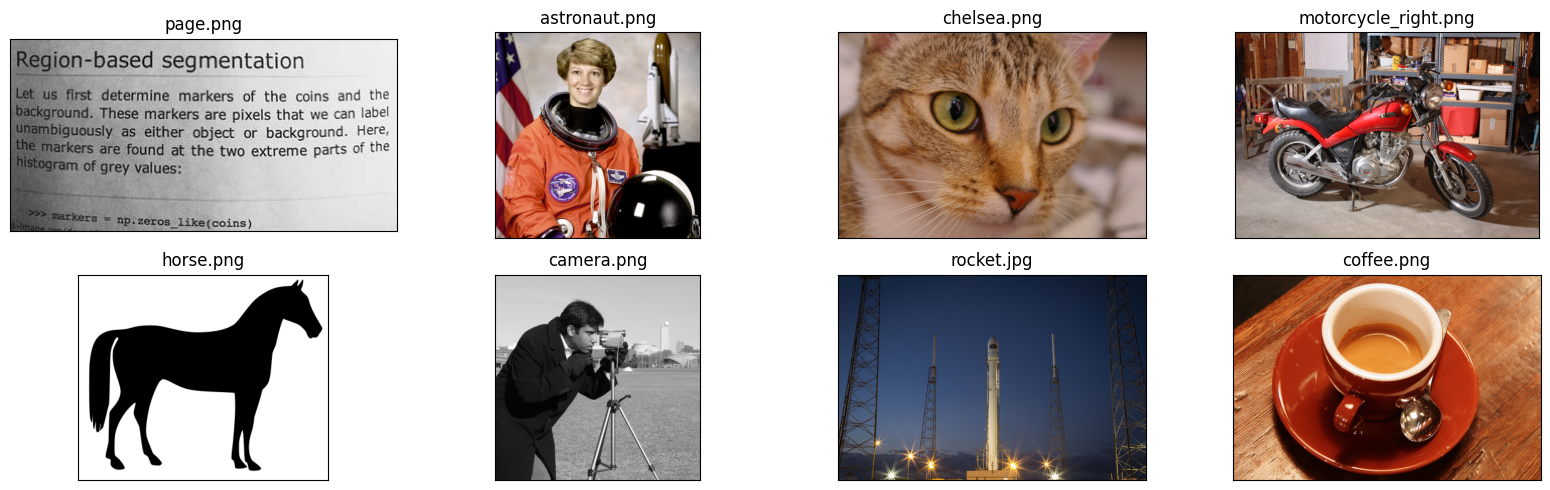

In [7]:
import skimage

original_images = []
images = []
texts = []
plt.figure(figsize=(16, 5))

for filename in [filename for filename in os.listdir(skimage.data_dir) if filename.endswith(".png") or filename.endswith(".jpg")]:
    name = os.path.splitext(filename)[0]
    if name not in descriptions:
        continue

    image = Image.open(os.path.join(skimage.data_dir, filename)).convert("RGB")

    plt.subplot(2, 4, len(images) + 1)
    plt.imshow(image)
    plt.title(f"{filename}")
    plt.xticks([])
    plt.yticks([])

    original_images.append(image)
    images.append(preprocess(image))
plt.tight_layout()

In [8]:
image_input = torch.tensor(np.stack(images))
with torch.no_grad():
    image_features = clip_model.encode_image(image_input).float()

image_features /= image_features.norm(dim=-1, keepdim=True)

In [8]:
def plotting_function(file_name: str):

  text_descriptions = []

  with open(file_name, "r") as file:
    for line in file:
        text_descriptions.append(line.strip())

  text_tokens = tokenizer.tokenize(text_descriptions)

  with torch.no_grad():
    text_features = clip_model.encode_text(text_tokens).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)

  text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
  top_probs, top_labels = text_probs.cpu().topk(5, dim=-1)

  plt.figure(figsize=(16, 16))

  for i, image in enumerate(original_images):
      plt.subplot(4, 4, 2 * i + 1)
      plt.imshow(image)
      plt.axis("off")

      plt.subplot(4, 4, 2 * i + 2)
      y = np.arange(top_probs.shape[-1])
      plt.grid()
      plt.barh(y, top_probs[i])
      plt.gca().invert_yaxis()
      plt.gca().set_axisbelow(True)
      plt.yticks(y, [text_descriptions[index] for index in top_labels[i].numpy()])
      plt.xlabel("probability")

  plt.subplots_adjust(wspace=0.5)
  plt.show()

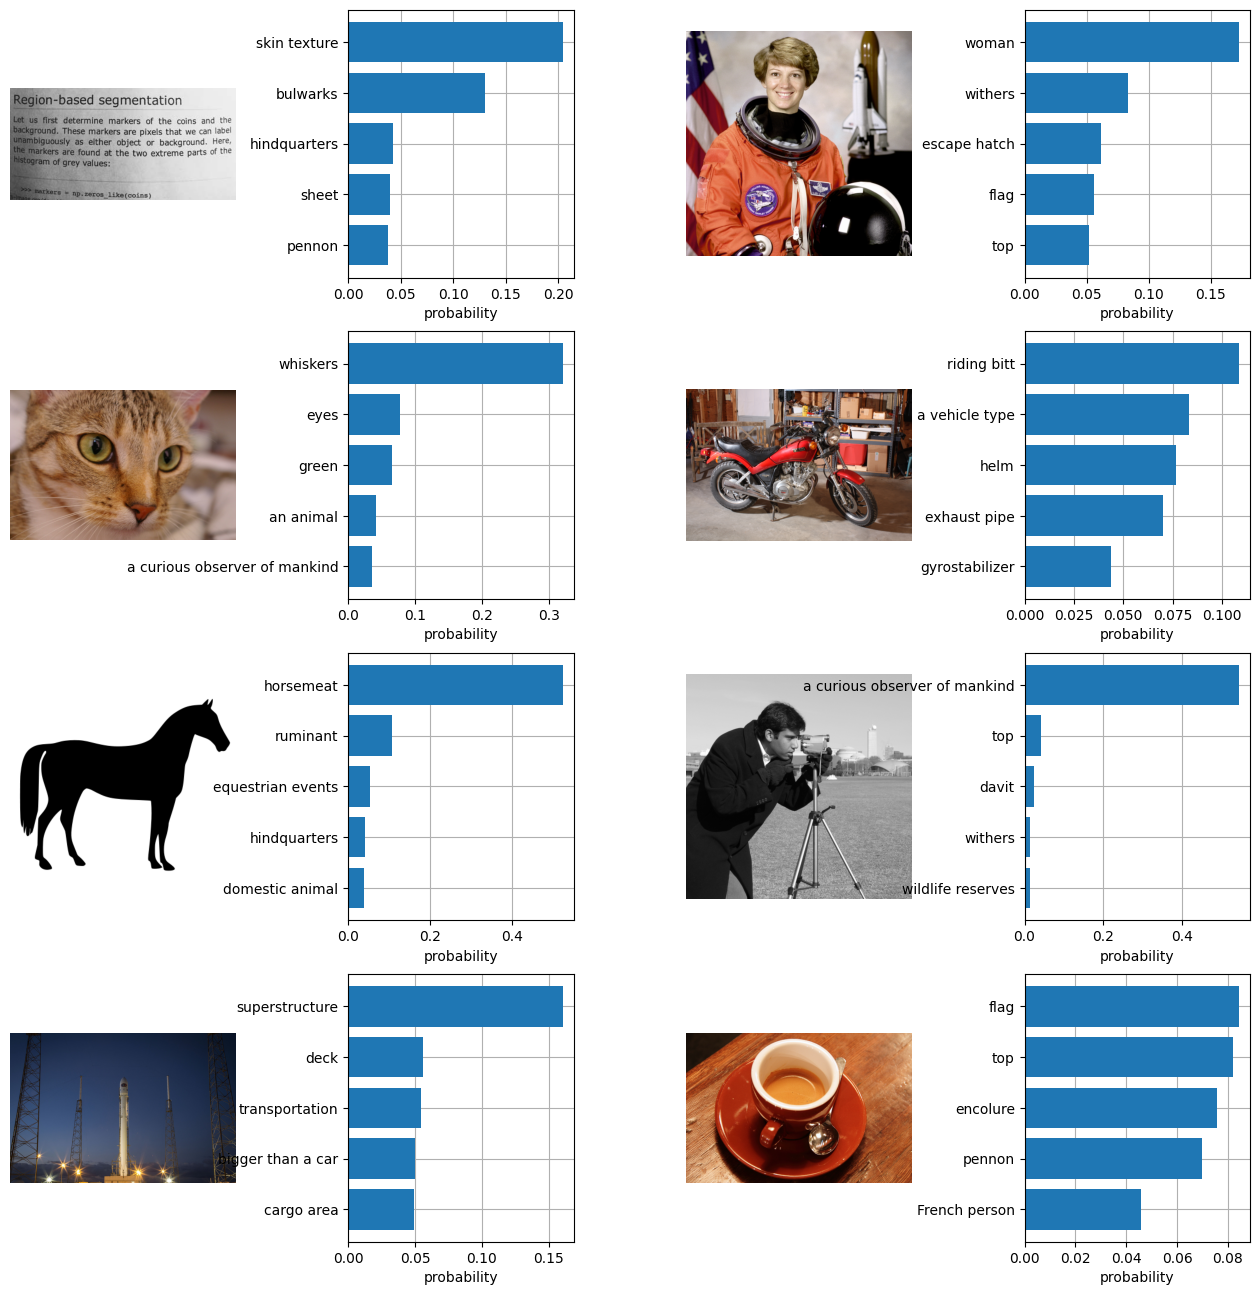

In [9]:
plotting_function("data/gpt_conceptnet_cifar10_filtered.txt")

In [ ]:
text_descriptions = []

with open("data/conceptnet_cifar10_filtered_new.txt", "r") as file:
  for line in file:
      text_descriptions.append(line.strip())

text_tokens = tokenizer.tokenize(text_descriptions)

with torch.no_grad():
  text_features = clip_model.encode_text(text_tokens).float()
  text_features /= text_features.norm(dim=-1, keepdim=True)

text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
top_probs, top_labels = text_probs.cpu().topk(5, dim=-1)

end of test

In [ ]:
original_images = []
images = []
texts = []

for filename in [filename for filename in os.listdir("/content/") if filename.endswith(".png") or filename.endswith(".jpg")]:
    image = Image.open(os.path.join("/content/", filename)).convert("RGB")
    images.append(preprocess(image))
    original_images.append(image)


image_input = torch.tensor(np.stack(images))
with torch.no_grad():
    image_features = clip_model.encode_image(image_input).float()

image_features /= image_features.norm(dim=-1, keepdim=True)

In [ ]:
def plotting_function(file_name: str):

  text_descriptions = []

  with open(file_name, "r") as file:
    for line in file:
        text_descriptions.append(line.strip())

  text_tokens = tokenizer.tokenize(text_descriptions)

  with torch.no_grad():
    text_features = clip_model.encode_text(text_tokens).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)

  text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
  top_probs, top_labels = text_probs.cpu().topk(5, dim=-1)

  plt.figure(figsize=(16, 16))

  for i, image in enumerate(original_images):
      plt.subplot(4, 4, 2 * i + 1)
      plt.imshow(image)
      plt.axis("off")

      plt.subplot(4, 4, 2 * i + 2)
      y = np.arange(top_probs.shape[-1])
      plt.grid()
      plt.barh(y, top_probs[i])
      plt.gca().invert_yaxis()
      plt.gca().set_axisbelow(True)
      plt.yticks(y, [text_descriptions[index] for index in top_labels[i].numpy()])
      plt.xlabel("probability")

  plt.subplots_adjust(wspace=0.5)
  plt.show()

# Classifier

In [ ]:
with open("data/all_classes.txt", "r") as f:
  classes = f.read().split("\n")

with open("data/all_concepts.txt", "r") as f:
  concepts = f.read().split("\n")

vocab = classes + concepts

unique = []
for item in vocab:
  if item not in unique:
    unique.append(item)

vocab = unique

In [ ]:
def word_tokenize(List: list) -> list:

  tokenizer = WordPunctTokenizer()

  List = [item.lower() for item in List]
  List = [tokenizer.tokenize(item) for item in List]

  temp_list = []

  for item in List:
      joined_item = ' '.join(item).replace(' - ', '-').replace(' .', '.')
      joined_item = joined_item.replace(' ( ', ' (').replace(' ) ', ') ')
      item = [joined_item]
      temp_list.append(item)

  List = temp_list

  return List

In [ ]:
from gensim.models import Word2Vec

vocab = word_tokenize(vocab)
cls_model = Word2Vec(vocab,
                     vector_size=300,
                     min_count=0,
                     window=5).wv

only for cifar10 classification

In [ ]:
with open("data/cifar10_classes.txt", "r") as f:
  cifar10_classes = f.read().split("\n")

cifar10_classes = word_tokenize(cifar10_classes)

In [ ]:
for i, image in enumerate(original_images):

  cls_result_dict = {"the biggest similarity": -1.0, "name of class": ""}
  image_concepts = [text_descriptions[index] for index in top_labels[i].numpy()]
  image_concepts = word_tokenize(image_concepts)

  for cls in cifar10_classes:
    biggest = np.sum([custom_model.similarity(''.join(cls), ''.join(cpt)) for cpt in image_concepts])
    if biggest > cls_result_dict["the biggest similarity"]:
      cls_result_dict["the biggest similarity"] = biggest
      cls_result_dict["name of class"] = ''.join(cls)


  print("for {} the predicted class is {}".format(i, color.BOLD + cls_result_dict["name of class"] + color.END))